# LAB | Imbalanced

**Load the data**

In this challenge, we will be working with Credit Card Fraud dataset.

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/card_transdata.csv

Metadata

- **distance_from_home:** the distance from home where the transaction happened.
- **distance_from_last_transaction:** the distance from last transaction happened.
- **ratio_to_median_purchase_price:** Ratio of purchased price transaction to median purchase price.
- **repeat_retailer:** Is the transaction happened from same retailer.
- **used_chip:** Is the transaction through chip (credit card).
- **used_pin_number:** Is the transaction happened by using PIN number.
- **online_order:** Is the transaction an online order.
- **fraud:** Is the transaction fraudulent. **0=legit** -  **1=fraud**


In [18]:
#Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [2]:
fraud = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/card_transdata.csv")
fraud.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [15]:
def data_exploration(df):

    # check number of rows and columns
    shape = df.shape
    print("Number of rows:", shape[0])
    print("Number of columns:", shape[1])

    # check duplicates
    check_duplicates = df.duplicated().sum()
    print("Number of duplicates:", check_duplicates)

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
                        'Column': df.columns,
                        'Data Type': df.dtypes,
                        'Non-Null Count': df.notnull().sum(),
                        'Missing Values': df.isnull().sum(),
                        'Unique Values': df.nunique()
                })

    # Reset index to make 'Column' a regular column
    summary_df.reset_index(drop=True, inplace=True)

    # Display the summary DataFrame
    summary_df
    
    # check numerical columns
    numerical_columns = df.select_dtypes("number").columns
    print("\nNumerical Columns:", numerical_columns)

    # check categorical columns
    categorical_columns = df.select_dtypes("object").columns
    print("\nCategorical Columns:", categorical_columns)

    return summary_df

In [16]:
data_exploration(fraud)

Number of rows: 70018
Number of columns: 8
Number of duplicates: 0

Numerical Columns: Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order', 'fraud'],
      dtype='object')

Categorical Columns: Index([], dtype='object')


,Column,Data Type,Non-Null Count,Missing Values,Unique Values
0,distance_from_home,float64,70018,0,70018
1,distance_from_last_transaction,float64,70018,0,70018
2,ratio_to_median_purchase_price,float64,70018,0,70018
3,repeat_retailer,float64,70018,0,2
4,used_chip,float64,70018,0,2
5,used_pin_number,float64,70018,0,2
6,online_order,float64,70018,0,2
7,fraud,int32,70018,0,1


**Steps:**

**1.** What is the distribution of our target variable? Can we say we're dealing with an imbalanced dataset?

In [5]:
fraud['fraud'].value_counts()

fraud
0.0    912597
1.0     87403
Name: count, dtype: int64

Yes, we are dealing with imbalanced dataset because the legit one has more values than the fraud one. 

**2.** Train a LogisticRegression.

In [6]:
# Select features and target
features = fraud.drop(columns=["fraud"])
target = fraud["fraud"]

# Convert the target into a binary classification
# For example, we can classify houses as "expensive" if they're above the median
target_binary = (target > target.median()).astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target_binary, test_size=0.20, random_state=0)

# Normalize the features
normalizer = MinMaxScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

# Create and train the logistic regression model
log_reg = LogisticRegression(random_state=0, max_iter=1000)
log_reg.fit(X_train_norm, y_train)

# Make predictions
pred = log_reg.predict(X_test_norm)

**3.** Evaluate your model. Take in consideration class importance, and evaluate it by selection the correct metric.

In [7]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, pred))
print("\nClassification Report:\n", classification_report(y_test, pred))

# Optionally, you can examine the coefficients to see feature importance
log_reg_coef = {feature: coef for feature, coef in zip(X_train.columns, log_reg.coef_[0])}
print("Feature coefficients:", log_reg_coef)

Accuracy: 0.945495

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97    182615
           1       0.92      0.41      0.57     17385

    accuracy                           0.95    200000
   macro avg       0.93      0.70      0.77    200000
weighted avg       0.94      0.95      0.94    200000

Feature coefficients: {'distance_from_home': 55.12770970550689, 'distance_from_last_transaction': 11.139914118277328, 'ratio_to_median_purchase_price': 148.50207905511, 'repeat_retailer': -0.19983800020016312, 'used_chip': -0.7390980898558032, 'used_pin_number': -7.607836501361241, 'online_order': 4.11164985140014}


**4.** Run **Oversample** in order to balance our target variable and repeat the steps above, now with balanced data. Does it improve the performance of our model? 

In [8]:
train = pd.DataFrame(X_train_norm, columns = X_train.columns)

In [9]:
train["fraud"] = y_train.values

In [10]:
train

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,0.000331,0.000083,0.002352,1.0,1.0,0.0,1.0,0
1,0.003688,0.000002,0.002246,1.0,1.0,0.0,1.0,0
2,0.005209,0.000082,0.001718,1.0,0.0,0.0,1.0,0
3,0.000056,0.000045,0.001963,0.0,1.0,0.0,0.0,0
4,0.002078,0.000002,0.002453,1.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
799995,0.006690,0.000262,0.000437,1.0,0.0,0.0,1.0,0
799996,0.000315,0.001097,0.007914,1.0,0.0,0.0,1.0,0
799997,0.002521,0.000372,0.001792,1.0,0.0,1.0,0.0,0
799998,0.001142,0.000003,0.006678,1.0,0.0,0.0,1.0,0


In [11]:
fraud = train[train["fraud"] == 1]
no_fraud = train[train["fraud"] == 0]

In [43]:
yes_fraud_oversampled = resample(fraud,       # we want to recreate more data
                                    replace=True, 
                                    n_samples = len(no_fraud),
                                    random_state=0)

In [44]:
train_over = pd.concat([yes_fraud_oversampled, no_fraud])
train_over

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
779963,0.000302,0.000903,0.035604,1.0,0.0,0.0,1.0,1
496591,0.022409,0.000217,0.010501,1.0,0.0,0.0,1.0,1
485804,0.002814,0.000282,0.021233,1.0,1.0,0.0,1.0,1
522876,0.000104,0.000643,0.015648,0.0,0.0,0.0,0.0,1
241477,0.015858,0.000199,0.001066,1.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...
799995,0.006690,0.000262,0.000437,1.0,0.0,0.0,1.0,0
799996,0.000315,0.001097,0.007914,1.0,0.0,0.0,1.0,0
799997,0.002521,0.000372,0.001792,1.0,0.0,1.0,0.0,0
799998,0.001142,0.000003,0.006678,1.0,0.0,0.0,1.0,0


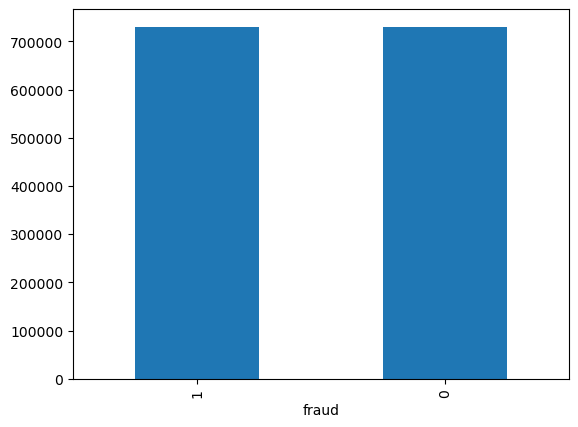

In [28]:
fraud_plt = train_over["fraud"].value_counts()
fraud_plt.plot(kind="bar")
plt.show()

- Now, with balanced data, we will create a new instance of Logistic Regression.

In [20]:
X_train_over = train_over.drop(columns = ["fraud"])
y_train_over = train_over["fraud"]

In [21]:
log_reg = LogisticRegression()
log_reg.fit(X_train_over, y_train_over)

LogisticRegression()

In [22]:
pred = log_reg.predict(X_test_norm)
print(classification_report(y_pred = pred, y_true = y_test))

c:\Users\Gebruiker\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      0.92      0.96    182615
           1       0.54      0.93      0.68     17385

    accuracy                           0.92    200000
   macro avg       0.76      0.93      0.82    200000
weighted avg       0.95      0.92      0.93    200000



**5.** Now, run **Undersample** in order to balance our target variable and repeat the steps above (1-3), now with balanced data. Does it improve the performance of our model?

In [40]:
no_fraud_undersampled = resample(no_fraud, 
                                    replace=False, 
                                    n_samples = len(fraud),
                                    random_state=0)
no_fraud_undersampled

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
290678,0.004119,0.000020,0.007801,1.0,0.0,0.0,1.0,0
199161,0.001052,0.003951,0.000959,1.0,0.0,0.0,1.0,0
238970,0.006899,0.000437,0.001052,1.0,0.0,1.0,0.0,0
500779,0.002317,0.000003,0.003529,1.0,1.0,0.0,1.0,0
251427,0.000776,0.000029,0.002221,1.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...
534039,0.000552,0.000501,0.002651,1.0,0.0,0.0,1.0,0
342411,0.002954,0.000018,0.004391,1.0,0.0,0.0,1.0,0
400406,0.001626,0.000003,0.001873,1.0,0.0,0.0,0.0,0
526304,0.000141,0.000027,0.024870,0.0,1.0,0.0,0.0,0


In [41]:
train_under = pd.concat([no_fraud_undersampled, fraud])
train_under

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
290678,0.004119,0.000020,0.007801,1.0,0.0,0.0,1.0,0
199161,0.001052,0.003951,0.000959,1.0,0.0,0.0,1.0,0
238970,0.006899,0.000437,0.001052,1.0,0.0,1.0,0.0,0
500779,0.002317,0.000003,0.003529,1.0,1.0,0.0,1.0,0
251427,0.000776,0.000029,0.002221,1.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...
799941,0.000419,0.001097,0.066801,1.0,1.0,0.0,1.0,1
799947,0.011019,0.000104,0.000503,1.0,0.0,0.0,1.0,1
799959,0.000671,0.000013,0.014943,1.0,0.0,0.0,1.0,1
799960,0.013652,0.000002,0.002138,1.0,0.0,0.0,1.0,1


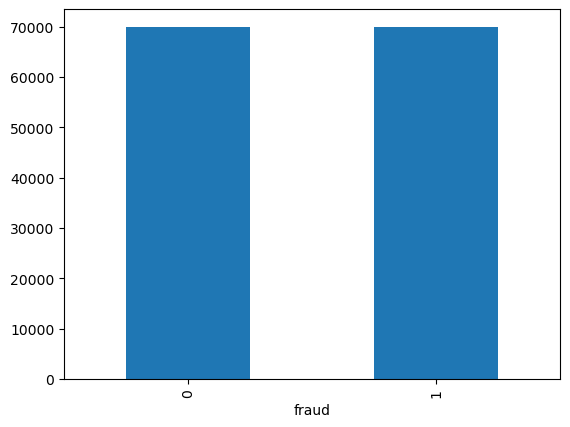

In [32]:
fraud_plt = train_under["fraud"].value_counts()
fraud_plt.plot(kind="bar")
plt.show()

- Separating our features from our target

In [33]:
X_train_under = train_under.drop(columns = ["fraud"])
y_train_under = train_under["fraud"]

- Model training

In [34]:
log_reg = LogisticRegression()
log_reg.fit(X_train_under, y_train_under)

LogisticRegression()

- Evaluate our model

In [35]:
pred = log_reg.predict(X_test_norm)
print(classification_report(y_pred = pred, y_true = y_test))

c:\Users\Gebruiker\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      0.89      0.94    182615
           1       0.45      0.91      0.60     17385

    accuracy                           0.90    200000
   macro avg       0.72      0.90      0.77    200000
weighted avg       0.94      0.90      0.91    200000



**6.** Finally, run **SMOTE** in order to balance our target variable and repeat the steps above (1-3), now with balanced data. Does it improve the performance of our model? 

- Sampling Strategy

In [36]:
sm = SMOTE(random_state = 1,sampling_strategy=1.0)

In [37]:
X_train_sm,y_train_sm = sm.fit_resample(X_train_norm,y_train)

- Now lets train our model, to see if get any improvements.

In [38]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_sm, y_train_sm)

LogisticRegression(max_iter=1000)

- Evaluate our model

In [39]:
pred = log_reg.predict(X_test_norm)
print(classification_report(y_pred = pred, y_true = y_test))

              precision    recall  f1-score   support

           0       0.99      0.92      0.96    182615
           1       0.54      0.93      0.68     17385

    accuracy                           0.92    200000
   macro avg       0.77      0.93      0.82    200000
weighted avg       0.95      0.92      0.93    200000

